<a href="https://colab.research.google.com/github/NamanChaudhary/NamanRepository/blob/master/Copy_of_Drive_FUSE_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.constraints import MaxNorm

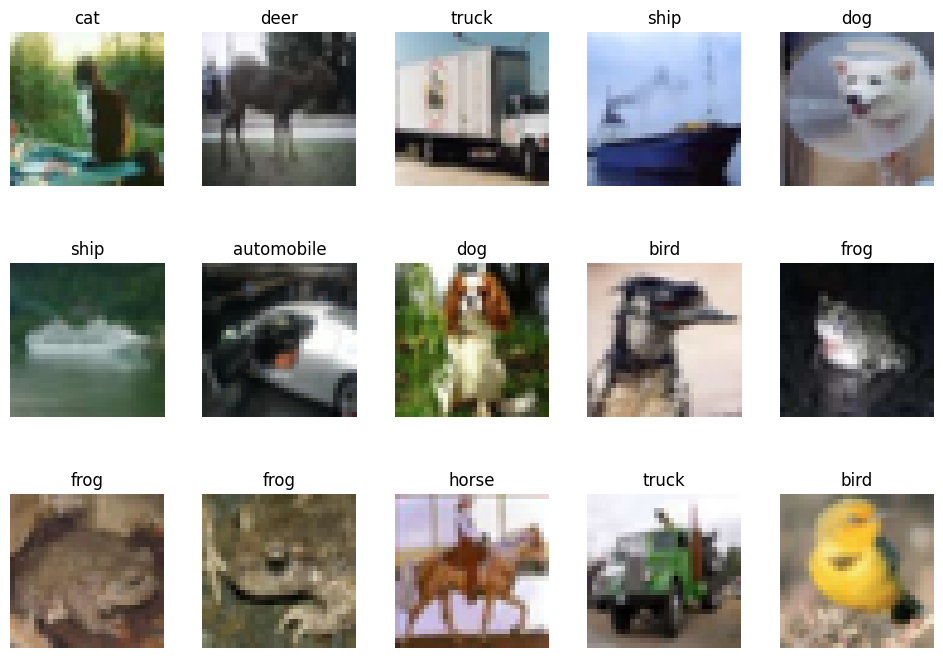

In [ ]:
# Assuming x_train, y_train are loaded and contain CIFAR-10 data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
for i in range(15):
    index = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[index])
    axes[i].set_title(class_names[y_train[index][0]])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)

<ipython-input-26-d25648d9713e>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(class_names, rotation = 90)


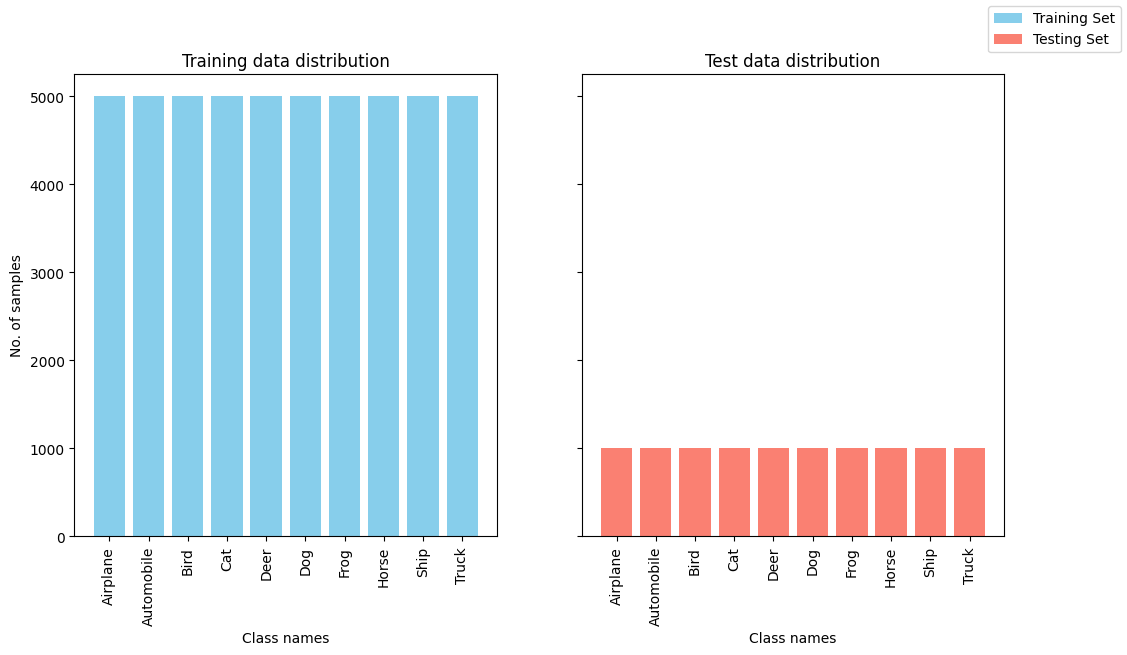

In [ ]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot training set distribution
axs[0].bar(class_names, train_counts, color='skyblue')
axs[0].set_title('Training data distribution')
axs[0].set_xlabel('Class names')
axs[0].set_ylabel('No. of samples')
axs[0].set_xticklabels(class_names, rotation = 90)
# Plot testing set distribution
axs[1].bar(class_names, test_counts, color='salmon')
axs[1].set_title('Test data distribution')
axs[1].set_xlabel('Class names')

# Add a legend to clarify the colors represent training and testing sets
fig.legend(['Training Set', 'Testing Set'])

# plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [ ]:
#This part is to describe the parametes, you can check below for a mode compact model version
num_classes=10

# Create the model
model = Sequential()
model.add(
    Conv2D(
        filters=32,                    # Number of output filters/channels
        kernel_size=(3, 3),            # Size of the convolution window
        strides=1,                     # Step size of the convolution
        padding='same',                # Padding strategy (same means output size will be made same as input size)
        input_shape=(32, 32, 3),       # Input dimensions (height, width, channels)
        kernel_initializer='he_normal',# Weight initialization method
        activation='relu'              # Activation function
    )
)


model.add(BatchNormalization())      # Normalize activations for faster training
model.add(Dropout(0.2))              # Randomly drop 20% neurons to prevent overfitting

# Second Convolutional Layer in First Block
model.add(
    Conv2D(
        filters=32,                    # Number of output filters/channels
        kernel_size=(3, 3),            # Size of the convolution window
        strides=1,                     # Step size of the convolution
        padding='same',                # Padding strategy
        kernel_initializer='he_normal', # Weight initialization method
        activation='relu'              # Activation function
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D())              # Reduce spatial dimensions by half (16x16)

# Second Convolutional Block - Doubled filters (64)
model.add(Conv2D(64,
                 (3, 3),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second Convolutional Layer in Second Block
model.add(Conv2D(64,
                 (3, 3),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())  # Further reduce spatial dimensions (8x8)


# Third Convolutional Block - Doubled filters (128)
model.add(Conv2D(128,
                 (5, 5),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second Convolutional Layer in Third Block
model.add(Conv2D(128,
                 (5, 5),
                 strides=1,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D())                   # Final spatial dimension reduction (4x4)

# Forth Convolutional Block - Doubled filters (256)
model.add(Conv2D(256,
                 (3, 3),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second Convolutional Layer in Third Block
model.add(Conv2D(128,
                 (3, 3),
                 strides=1,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D())                   # Final spatial dimension reduction (4x4)

# Global Average Pooling to replace Flatten
# Reduces parameters and maintains spatial information
model.add(GlobalAveragePooling2D())

# Final Dropout before classification
model.add(Dropout(0.2))

# Output layer with softmax activation for 10-class classification
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#filepath to save the best model
filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.weights.h5"         # when save_weights_only=True

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)
#Define callback
callbacks=[modelcheckpoint]
#Training the model
# 320000 training samples, batch size =32 , 320000/32=1000
train_datagen = ImageDataGenerator()
(X_train, y_train) = cifar10.load_data()
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=valid_datagen.flow(X_valid, y_valid, batch_size=32),
    epochs=100,                        # Set a high number of epochs
    callbacks=callbacks                # Include the early stopping callback
)

#------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 8, 8, 128)           │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 4, 4, 256)           │           1,0

 Total params: 1,274,026 (4.86 MB)

 Trainable params: 1,272,874 (4.86 MB)

 Non-trainable params: 1,152 (4.50 KB)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 10000) + inhomogeneous part.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#filepath to save the best model
filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.weights.h5"         # when save_weights_only=True

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)
#Define callback
callbacks=[modelcheckpoint]
#Training the model
# 320000 training samples, batch size =32 , 320000/32=1000
history = model.fit(
    train_datagen.flow(x_train1, y_train1, batch_size=32),
    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=32),
    epochs=100,                        # Set a high number of epochs
    callbacks=callbacks                # Include the early stopping callback
)

#------------------------------------------------------------------------------------------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 289,578 (1.10 MB)

 Trainable params: 288,938 (1.10 MB)

 Non-trainable params: 640 (2.50 KB)

NameError: name 'x_train1' is not defined

In [ ]:
num_classes=10

#Compact model version
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(32, 32, 3), kernel_initializer='he_normal', activation='relu' ))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#filepath to save the best model
filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.weights.h5"         # when save_weights_only=True

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)
#Define callback
callbacks=[modelcheckpoint]


#Training the model
# 320000 training samples, batch size =32 , 320000/32=1000
history = model.fit(
    train_datagen.flow(x_train1, y_train1, batch_size=32),
    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=32),
    epochs=100,                        # Set a high number of epochs
    callbacks=callbacks                # Include the early stopping callback
)

#------------------------------------------------------------------------------------------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 289,578 (1.10 MB)

 Trainable params: 288,938 (1.10 MB)

 Non-trainable params: 640 (2.50 KB)

NameError: name 'train_datagen' is not defined